In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import norm
from statsmodels.stats.proportion import confint_proportions_2indep
from statsmodels.stats.proportion import proportions_ztest
# import the beta function from scipy.special
from scipy.special import beta as beta_function

# AB Test Methodologies Comparison : Null Hypothesis Significance Testing vs. Bayesian

In the context of launching passkeys and comparing the abandonment rates and benefit of the UX variants we want to test, this notebook is a comparison of classic Null Hypothesis Significance Testing which is the method used by traditional statisticianss for decades but which are concpetually complex and hard to truly interpret,  with Baysian methods which are gaining more and more traction and they provide more flexibility and better direct interpretability for decision making like for decide when and how to switch more traffic from a control to a variant or between variants

## General Structure of the test between : Control C and Variants A1, A2, A3 ...

We have an existing journey to create customer digital identiy and create credentials which has a completion rate of x% , for the same of this discussion we will use an example success rate of 20% (that is 80% of user abandoning).

We are going to keep 90% of the traffic on the legacy/existing pages as a controld group and test n variants $A_i$ We want to make sure the new proposed CX is not worse or better than the control, at which point we will switch all traffic to the variants, then rate the variants against each other.

The type of AB test where one want to see whether somethig new is not "making things worse" i.e. somehow degrading the experience is usually called a "non inferiority test" (see below)

## Null Hypothesis Significance Testing (NHST) Methodology

At a high level the methdology is : assume what you don't want to see or heave, call it the null hypothesi for instanc teh drug has no effect or in our cuase the new experience singifianctly increase abandonment, run the test, look at the result if and if the result looks  unlikely enoug as if low enough probabitliy to happe (e.g. like that 5% to see what we observe) under the Null Hypothesis, then reject the hypothesis. Note 2 thing immedialy youi havent really said wether the oppostive hypothesis is true, just that your reject the null. Also "unlikely enough" is defined buy a somewhat arbitrary number (5% chance).

The method boils down to compute the probability of the observation given the hypothesis, as we will see later the Bayesian approach is going the other way, it computes the probabilty of the hypothesis given the observation, which is a totally different metric

### Framing of the problem using Random Variables

This abandonment rate of a  UX is usually modelled as 2 Bernoulli Random Variables $X_C$ and $X_A$ from which we will draw repeadetly. Bernoiulli just mean we present a choice with only 2 possible outcome success/failure, connvert/abandon, up/down etc.. presenting the new CX repeatedly to a bunch of end users.

$X_C$ being the UX and Bernoulli RV presented to control control group  $X_A$ being the variant A presented. They are both assumed to have for codomain $\mathcal{X}_C=\mathcal{X}_A=\{0,1\}$ that is a boolean i.e. it converts or does not convert. Here "convert" means the user perform the action they intended to do vs. abandoning the journey, e.g. create a passkey. There a possiblty with a techincal failure but this would not be their choice so it woudl be counted as a success for the purpose of this AB test.

The way NHST usually model the difference between a contrl and variant convertion rate is to define a new random varaibles called the "sample proportions" which is the sum of n instances of the Bernoulli ones defined above, divided by n. For this "sample proportion" Let's using the notation  $\hat{p}_C$ and $\hat{p}_A$ for the control and the variant respectively , defined as

 $ \hat{p_C}=\frac{1}{n}\sum_1^n X_{Ci}$ and 
 $ \hat{p_A}=\frac{1}{n}\sum_1^n X_{Ai}$
 
 each sample proportion can be interprested as 2 things :

* $ \hat{p_C}$ and  $ \hat{p_A}$ can be interpresetd as an ordinary random variables with codomain $\{0,\frac{1}{n},\frac{2}{n},...\frac{n}{n}\}$
* $\hat{p_C}$ and  $ \hat{p_A}$ can also be intepreted as estimators (in the technical sense of the word "estimator" used in classical statistics) of the expected value $E(p_C)$ and $E(p_A)$. In general regardless of whether it is a control or a variant $E(\hat{p}) \rightarrow E(p)$ because of the law of large numbers applied to a Bernoulli/Binomial.

The notaiton with a "little hat" over the letter is the convention in statics for denote estimators.

An estimator is a function from the n-cartesian product of the space of realizations of X (on itself n times)  to the domain of the parameter of interest, if we  use the notation codomain(X) = $\mathcal{X}$, it is then a maaping from $\mathcal{X}^n$ to some real value for a paraemter of original random variable X, in this case $\hat{p}_A: \mathcal{X}^n \rightarrow \{0,\frac{1}{n},\frac{2}{n},...,\frac{n}{n}\}$ Because it it is a sum of Bernoullis, the estimator RV follows binomial distribution centered on the expected value. It is always true that a discrete binomial distirubtion can be approximated by a contunous gaussian as n grows (clipping the tails)


#### Variance and standard devation of a sum of Bernoulli or Binomial

in all the rest of the discussion we are going to use a lot of the variance and standard devaition of the sample proporotion as it it used to defined what is called the "standard error" under various hypothesis. This is just a reminder of how tehy are computed

Note that for a "single" Bernoulli random variable $X$ we have $Var(X) = p (1-p)$ and therefore 
  
$Var(\frac{1}{n}\sum_1^n X_i) = \frac{1}{n^2}Var(\sum_1^n X_i)$

$Var(\frac{1}{n}\sum_1^n X_i) = \frac{1}{n^2}n(p(1-p))$


$Var(\frac{1}{n}\sum_1^n X_i) = \frac{1}{n}(p(1-p))$

so $\boxed{Var(\hat{p})= \frac{p(1-p)}{n}}$



###  Notation for the  Estimator of the difference in proportions

To make the rest of the discussion easier to read  we are going to define the difference in estimator $\hat{p_A}$ and $\hat{p_C}$ as $\hat\Delta = \hat{p_A} - \hat{p_C}$ which is also an estimator of the expected value of random varaible $\Delta = p_A - p_C$


### Null Hypothesis (H₀):


As we said earlier the  "effect" we are trying to avoid is if the new passkey creation pages would degrade the overall UX  so much that it may impacts our other business metrics. In the classical framing of a non-inferiotity test, the  Null Hypothesis is the "bad thing" we are tryigng to reject in our case it would mean : "some degration".

"some degration" can be described with a simple inequality like  $E(p_A) \le E(p_C) - \epsilon $ where $\epsilon$ is a tiny degradation we would find acceptable for instance 0.03 (3%).

We will rewrite

$H_0$ as $\boxed{H_0 = E(\Delta) \leq -\epsilon}$




### Alternative Hypothesis (H₁):
 The conversion rate for the variant is higher than $\boxed{E(\Delta) > -\epsilon}$



### Boundary Hypothesis

Below we will make use of the hyoptheis that the difference in conversion is exactly the snall accetable one  that is

$\boxed{E(\Delta) = -\epsilon}$


#### Numerical example 

Each realization is given after each experience by the folowing counts

$n_C$: Number of visitors in the control group

$x_C$ : Number of conversions observed (realization) in a given control group

$n_A$: Number of visitors in the variant group

$x_A$ : Number of conversions observed (realization) in the variant group

$\hat{\Delta_{obs}}$ the observed value of the difference between the proportions

$\epsilon$ : accetable degradation in the difference between the proportions



In [38]:
control_group_conversion_rate = 0.2 # based on historical data
nC = 7000
xC_observed = nC * control_group_conversion_rate
nA = 1000
xA_observed = 200
epsilon = 0.03
alpha = 0.05
hatpC_observed = xC_observed / nC
hatpA_observed = xA_observed  / nA
hatDelta_observed = hatpA_observed - hatpC_observed

print(f"Realization of difference in conversion rate estimator: {hatDelta_observed:.4f}")
print(f"Control group realization of conversion rate estimator: {hatpC_observed:.4f}")
print(f"Treatment group realization of conversion rate estimator: {hatpA_observed:.4f}")

Realization of difference in conversion rate estimator: 0.0000
Control group realization of conversion rate estimator: 0.2000
Treatment group realization of conversion rate estimator: 0.2000


### Standard Deviation of the estimator $\hat{\Delta}$ a.k.a Standard Error in frequentist/classic statistics.

The NHST methodolgy involve computing first an estimatation of the standard deviation for the estimator $\hat{\Delta}$, then to see how likely it then comparing it with the actual values we get from the difference in proportion in the experiment, then based on this decide if the difference observed is far enough (or close enough) to the theoritical value to reject or not reject the hypothesis based on some accpeted risks in the deicison rules (power, confidence internval)

THis is the first problem NHST has to tackle we have no idea what the true standar deviation is, so all varation on NHST use a "hack" they call the plug in principle, which basically use the current experiement results , to "plug in" some formula to esimate the unknown standard deviation. But note the circularity of the method:

1. We want to test if the data is unusual under H₀
2. To measure "unusual," we need the standard error under H₀
3. But SE depends on the unknown θ, so we plug in p̂ (the data itself!)
4. We then use this data-derived SE to judge whether the data is unusual

It's like: *Let me use my single measurement to tell me how variable my measurements are, then use that to decide if my measurement is surprising*

NHST proponent justify it because if ou repeateded the same experiment many times, at infinity would converge to the true value "on average".But you only have ONE sample!
You don't know if your particular p̂ is:
Close to the true value (plug-in works well)
An outlier (plug-in is terrible)

Why Frequentists live with it:

* Long-run frequency interpretation: "If we repeat this procedure many times, it has correct coverage"
* Pragmatism: They need something computable
* Simulation evidence: It works "reasonably well" in practice for moderate n, but "reasonably well" can be challeng see goole "the crisis of replication" to get a sense of the numerous failures.
* No alternative: In the frequentist framework, parameters are fixed unknowns, not random variables

### The various plugin Hacks


#### If hypotehsis is "no effect" the Wald pooling method:

If instead of "non inferiority" the null hypothesis  is "no effect" ( we will have that later for H1), the plug in hack is to record the observed conversion rates (estimators) for each proportion then  combine (pool) as under this very specific hypothesis they have the exact same expected value so a larger sample created through pooling is a better estimator of the true value, whatever it is.

the realization of $\hat{p}_A$  is $(\hat{p}_A(\omega) = \frac{x_A}{n_A})$

the associated realization of $\hat{p}_C$ is  $(\hat{p}_C(\omega) = \frac{x_C}{n_C})$

Then there is a theoritical estimator for the combine exeprience IF the null hypothesis was holding and there was not difference A and the control there woudl be a random variable for the estimator of both being pooled

$\hat{p}(\omega_{pool}) = \frac{x_A + x_V}{n_A + n_C}$

Then we try to compute the variance standard deviation of the difference between the conversion rate of the control vs. the variance. The variance of the difference beteww the 2 proportion is the sum of their variance, so

$Var(\hat{p}_A - \hat{p}_C ) = Var(\hat{p}_C) + Var(\hat{p}_A)$

Also because both $\hat{p_C}$ and $\hat{p_A}$ are Bernoulli RV, and using this "plug in " principal; we compute the sum of variance of the estimators also using the pooled sample reading as:

$Var(\hat{p}_A - \hat{p}_C ) = \frac{\hat{p}(\omega_{pool})(1- \hat{p}(\omega_{pool}))}{n_A} + \frac{\hat{p}(\omega_{pool})(1- \hat{p}(\omega_{pool}))}{n_C} = \hat{p}(\omega_{pool})(1- \hat{p}(\omega_{pool})) (\frac{1}{n_C} + \frac{1}{n_A})$

and the standard error which is just the standard deviation of the same quantity  also using the plug in principl the standard devation of the estimators that statisticain call "standard error" is

$\boxed{WaldPooled SE = \sqrt{\hat{p}(\omega_{pool})(1- \hat{p}(\omega_{pool})) (\frac{1}{n_C} + \frac{1}{n_A})}}$

this is sometimnes called "pooled standard error" or "standard error of the difference between two independent proportions"

From this we conmpute the z-score whuich is a dimenionless value counting the number of standard devaition that the difference observed is from the theoritical difference which shoiuld be zero under the null hypothesis (approximated by the pooled one, sktechy). So a simple ivisino of the observed devation over teh standard deviation of hte diference

$z= \frac{\frac{x_A}{n_A} - \frac{x_C}{n_C}}{SE}$



#### If hyopthesis is "non inferiority", use the Wald Unpooled Standard Error:

If the hypotheis is not "no effect", but "on inferioity" we cannot assume that each sample is drawn from the same random variable, we actually explicitely say it is not because of the epsilon among other thing. So the first quick and dirt approch is just to sum the separate variances (see above variance of Bernoulli) as variances are additive when random variable are added  or substracted in our case, and are assymed to be independent, then take the square roo t pf that sum to get to a standard deviation:

$\hat{WaldUnpooledSE} = \sqrt{\frac{\hat{p_A(w)}(1-\hat{p_A(w)})}{n_A} + \frac{\hat{p_C(w)}(1-\hat{p_C(w)})}{n_C}}$

Note that we should be using hte expected value of $E(p_A)$ and $E(p_B)$ in the formula but we don't know them, so we use the so call "plug in" trick and replace them but whatever values we get. That is why this is a quick and dirty approach that can produce questionable results depending on the specific phenomenon and sizes of samples.

#### Slightly Better for "non inferiority"  Newcombe (score-based / Wilson)

Much better actual coverage than Wald, especially with imbalanced samples or extreme p.
Still fairly simple to compute (closed-form formulas exist, or can be coded).

we wont' cover it here but it is still a plug-in hacks suffering from circularity argument and n=1 problem.

#### Miettinen–Nurminen

Widely used in clinical trials and non-inferiority contexts and in some regulated industry like pharmaceitical (recommended by the FDA)

Very complex and hard to explain, and is still fundmentally a plug in hack with the same circular reasoning and  n=1 We wont cover it.


Numerical examples

In [39]:
pooled_proportion = (xC_observed + xA_observed) / (nC + nA)
wald_pooled_SE = (pooled_proportion * (1 - pooled_proportion) * (1/nC + 1/nA))**0.5
print(f"Wald Pooled Standard Error: {wald_pooled_SE:.4f}")
wald_unpooled_SE = ((hatpC_observed * (1 - hatpC_observed) / nC) + (hatpA_observed * (1 - hatpA_observed) / nA))**0.5
print(f"Wald Unpooled Standard Error: {wald_unpooled_SE:.4f}")

Wald Pooled Standard Error: 0.0135
Wald Unpooled Standard Error: 0.0135


#### Probability of False Postive, pvalue, signifiance level $\alpha$ (a.k.a confidence by some people) and critical value


Once we approximated the  standard error SE (which is the standard devation of $\hat{\Delta}$) as explained above, teh NHST methodology then also fixed the expected value of $\hat{\Delta}$ under H0. The idea is that if you fix bothe the expected value and standar deviation , you can then work with a binomial or guassian probability distribution to compute whatever event probability you want. Even though the process is descrete and we should use a binomial continyusous gaussian are used in practice as htey are easier to manipulate in equations and are good approxmiation of binomial.




The other simplificaiton is that although H0 is an inquality $E(\Delta) \leq -\epsilon$ we are going to actuall use $E(\Delta) = -\epsilon$ to get a single probability distribution to work with, with the rationale that the boundary is the least favorable case, that is if we reject H0 at the boundary $-\epsilon$ logically we woudl reject it also at anythng with $E(\Delta) \leq -\epsilon$, as our observation woudl be get an even lower probability if the mean shifted  to the left.So using the boundary value epsilon is that one that makes it the most difficult to cross the alpha threshold and the most difficult to reject $H_0$

So with all that in place we can finally model H0 with a gaussian of mean $\mu = -\epsilon$ and standard deviation $\sigma = \hat{SE}$ 

$N(\mu, \sigma)$

Now we can compute the p-value which is the probability of observing or something like the sample we got or more extreme in the direction of H1. In our case it woudl be probability of the sample being in $[\hat{\Delta_{obs}}, +\infty]$ which can be comnputed by integrating the right tail of the gaussian from $\hat{\Delta_{obs}}$ to $+\infty$. This integral of the right tail is called the survival function of the gaussian and can be computed direct in python.




The direct way of computing the survival function and therefore the pvalue  directly from the observation $\hat{\Delta_{obs}}$ would be to integrate

pvalue $ = \int_{ \hat{\Delta_{obs}} }^{+\infty} \frac{1}{\sqrt{2 \pi}(SE)} e^{-\frac{(x - (-\epsilon))^2}{2(SE)^2}} dx$

Using a common notation where $\Phi$ is the cumulative distribtiuon of the standard normal N(0,1), the survival woudl altneratively expressed as this if one does not have something that conpute survial function directly

pvalue = $1 - \Phi(\frac{\hat{\Delta_{obs}} - \mu}{\sigma})$

that we will compare to the $\alpha$, in our case 0.05, if the the probability of seeing what we observed or something even more favorable (the right tail) is 5% or less, we reject the null hypothesis H0 because we are seeing is very unlikely under H0. The critical value is the inverse of the right tail integratiojn, is the the value of hte observation that would make the probabilit of seeing the sample 5% or lower in our setup. The formula to inverse it from the $\alpha$ is

$c = \mu  + \sigma \Phi^{-1}(1 - \alpha)$

Below is a full computation and a vizualization of the parameters along the right tail



In [44]:
SE_H0 = wald_unpooled_SE
from scipy.stats import norm

mu_H0 = -epsilon    # mean
sigma_HO = SE_H0  # standard deviation
x = hatDelta_observed  # value to evaluate

# Survival function P(X > x)
p_value = norm.sf(x, loc=mu_H0, scale=sigma_HO)
print(f'p-value (one-sided): {p_value:.4f}')

critical_value = norm.isf(alpha, loc=mu_H0, scale=sigma_HO)
print(f"Critical value for p-value={alpha:.4f}: {critical_value:.4f}")



p-value (one-sided): 0.0133
Critical value for p-value=0.0500: -0.0078


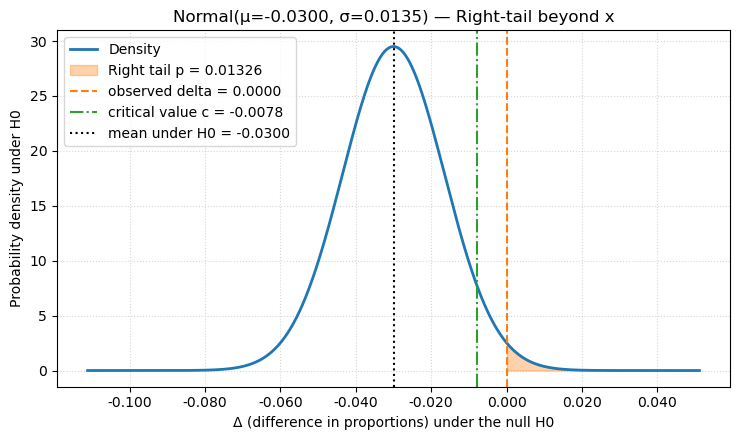

In [48]:
# Plot the Gaussian N(mu, sigma) and shade the right-tail area beyond x

# Use previously defined values; recompute to be robust
SE_H0 = wald_unpooled_SE
mu_H0 = -epsilon
sigma_HO = SE_H0
x0 = hatDelta_observed

# Domain for plotting (±6σ around the mean, clipped to reasonable bounds)
left = mu_H0 - 6 * sigma_HO
right = mu_H0 + 6 * sigma_HO
xs = np.linspace(left, right, 1000)
pdf = norm.pdf(xs, loc=mu_H0, scale=sigma_HO)

# Right-tail probability
p = norm.sf(x0, loc=mu_H0, scale=sigma_HO)

# Critical value at significance alpha (one-sided)
crit_x = norm.ppf(1 - alpha, loc=mu_H0, scale=sigma_HO)

# Plot
fig, ax = plt.subplots(figsize=(7.5, 4.5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.plot(xs, pdf, color="C0", lw=2, label="Density")

# Shade right tail
mask = xs >= x0
ax.fill_between(xs[mask], pdf[mask], color="C1", alpha=0.35, label=f"Right tail p = {p:.4g}")

# Vertical line at observed x
ax.axvline(x0, color="C1", ls="--", lw=1.5, label=f"observed delta = {x0:.4f}")

# Vertical line at critical value
ax.axvline(crit_x, color="C2", ls="-.", lw=1.5, label=f"critical value c = {crit_x:.4f}")

# Vertical line at the mean for the null hypothesis H0
ax.axvline(-epsilon, color="k", ls=":", lw=1.5, label=f"mean under H0 = {-epsilon:.4f}")

# Decorations
ax.set_title(f"Normal(μ={mu_H0:.4f}, σ={sigma_HO:.4f}) — Right-tail beyond x")
ax.set_xlabel("Δ (difference in proportions) under the null H0")
ax.set_ylabel("Probability density under H0")
ax.legend(loc="best")
ax.grid(True, ls=":", alpha=0.5)
plt.tight_layout()
# plt.show(), display handled by notebook



#### traditional presentation of the same conmputation using z-scores

The traditional ways for NHST to compute the p value is not to use the measurment $\hat{\Delta_{obs}}$ directly but to normalize it to a standard normal and centered on zero and on standard deviation 1 N(0,1). This mormalization is done by transforming the measurment into a so called z-score:

The the z-score is just the way you can rescale an arbitrary Gaussian to the Normal by substracting the meand and dividing by the standard deviation $Z = \frac{X-\mu}{\sigma}$

$Z_{NI} = \frac{\hat{\Delta} - (E(\Delta_{H_{boundary}}))}{SE}$ 

$= \frac{\hat{\Delta} - (-\epsilon)}{SE}$ 

$\boxed{Z_{NI}= \frac{\hat{\Delta} + \epsilon}{SE}}$

Then  $\frac{\hat{\Delta} + \epsilon}{SE}$ is a normal N(0,1) and 

$p(\hat{\Delta} \ge \hat{\Delta(w)})$

$ = p(\frac{\hat{\Delta} + \epsilon}{SE} \ge \frac{\hat{\Delta(w) +\epsilon}}{SE })$

Then we can compute the survial function but this timne on a standard normal and from the z-score value

$\int_{ Z_{NI} }^{+\infty} \frac{1}{\sqrt{2 \pi}} e^{-\frac{1}{2}z^2} dz$

which give the exact same results:



In [ ]:
zni = (hatDelta_observed + epsilon) / SE_H0
p_zni = norm.sf(zni)
print(f"z_NI: {zni:.4f}, p-value: {p_zni:.4f}")

z_NI: 2.2185, p-value: 0.0133


#### False positive
In this NHST the pvalue is also the probabilit of a false positive that is the probability of rejecting the null hopythisis (saying htere is no degration) while there is acxtually a degradation. So it is setup our risk of make the wrong decision is 5%

#### Probability of having false negative a.k.a type 2 error , Power and sample size required to get to signficance under those conditions

Conversely , "False negative" in the context of a non inferiority test is the probability of failing to reject given the fact that H1 is true, meaning we fail to clear the non inferiority test, while the new UX is actually non inferior (i.e. as good or better than the old one). So we have the same issue as for the false poistive computation, we have to pick a value for what expected value for the $\Delta$ but this time under H1. As we cannot really work with a range of expecgted value for $\Delta$  we need a single value to fix the gaussian we are going to integrate. Here possible choice is to also pick a boundary which is $E(\Delta) = E(p_C)$ so whatever the control group mean was or is (depending on how much historical data we have). This is usally called "minimum effect size we want to detect" as is really a business decision, it is a bit arbitrary. Pickig our baseline is just one option

To model the estimator under the alternative hypothesis H1, we nedd to pick another expected value for the $\Delta$, since this is for H1 which means the same or better, we pick the bare mimium we need to make that statement that is "teh same" and an expectd value of zero fro the Delta. Under these condition we can pool the samples to get an estimator of the variance and standard error as we are assuming they are distributed indentically

$SE | H1 = WaldPooled SE = \sqrt{\hat{p}(\omega_{pool})(1- \hat{p}(\omega_{pool})) (\frac{1}{n_C} + \frac{1}{n_A})}$

With that in place we compute the probabilit of the esimator coming up "higher" but with the same critical value as it was established ahead of time with the significance level alpha.

The Beta is the probability that we observed something lower and up to the the critical value defined but inverting the p-value but under H1, meaning the distribution is centered on the H1 expected value, in our case it is zero.

This computation will give su whatever it gives us, if we want to TARGET a Beta of 0.8, we can conpute the sample sizes (implied in SE) that will make us reach that level.



In [51]:
SE_H1 = wald_pooled_SE
mu_H1 = 0
sigma_H1 = SE_H1
x = critical_value
beta = norm.cdf(x, loc=mu_H1, scale=sigma_H1)
print(f"probability of false negative a.k.a β a.k.a type 2 errors,  at critical value : {beta:.4f}")
power = 1 - beta
print(f"Power (1 - β): {power:.4f}")


probability of false negative a.k.a β a.k.a type 2 errors,  at critical value : 0.2831
Power (1 - β): 0.7169


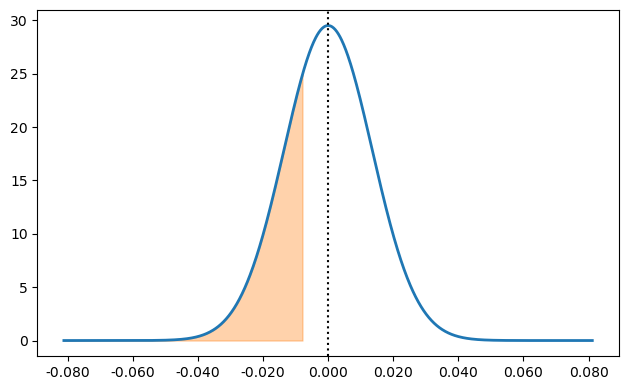

In [52]:

# Domain for plotting (±6σ around the mean, clipped to reasonable bounds)
left = mu_H1 - 6 * sigma_H1
right = mu_H1 + 6 * sigma_H1
xs = np.linspace(left, right, 1000)
pdf = norm.pdf(xs, loc=mu_H1, scale=sigma_H1)
# Plot
fig, ax = plt.subplots(figsize=(7.5, 4.5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.plot(xs, pdf, color="C0", lw=2, label="Density")

# Shade left tail
mask = xs <= critical_value
ax.fill_between(xs[mask], pdf[mask], color="C1", alpha=0.35, label=f"Left tail p = {critical_value:.4g}")

# Vertical line at the mean for the null hypothesis H1
ax.axvline(mu_H1, color="k", ls=":", lw=1.5, label=f"mean under H1 = {mu_H1:.4f}")

### Bayesian Approach

We will assume 2 prior distribution

For the control we have plently of historical data so we can take the historical and/or recent conversion as the baseline, no need to perform statististical inference on it. for the Variant A, assuming we start with an non informative prior (a.k.a uniform prior of) of

$Beta(1,1)$  

With the beta distribuction defined as 
 
representing the prior probability distribution of p_A, meaning that we have no idea, p_A could range from 0 to 1 with equal probability
 
after n trials and k success the posteriod probability distribution due to the property of the Beta function is
 
$Beta(xA +1,n_A − xA+1)$ 

This derived through Bayes Theorem and how the Beta function can be integrated

The expected value for $E(Beta(\alpha,\beta)) = \frac{\alpha}{\alpha + \beta}$

which for a bayesian posterior becomes

$E(Beta(xA+1,nA−xA+1)) = \frac{xA+1}{xA+1 + nA−xA+1} = \frac{xA+1}{nA+2}$

In [ ]:
expected_value_posterior = (xA_observed + 1) / (nA + 2)
print(f"Expected value of posterior distribution for p_A: {expected_value_posterior:.4f}")

Expected value of posterior distribution for p_A: 0.2006


In [ ]:
# Posterior parameters
alpha = xA_observed + 1
beta_param = nA - xA_observed + 1

# Ensure we use the beta distribution from scipy.stats
from scipy.stats import beta as beta_dist

# Compute 95% credible interval (2.5th and 97.5th percentiles)
p_L = beta_dist.ppf(0.025, alpha, beta_param)
p_U = beta_dist.ppf(0.975, alpha, beta_param)

# Output the result
print(f"95% Credible Interval for p: [{p_L:.4f}, {p_U:.4f}]")

95% Credible Interval for p: [0.1764, 0.2259]


In [33]:
# compute the 99% credible interval (1th and 99th percentiles)
p_L_99 = beta_dist.ppf(0.005, alpha, beta_param)
p_U_99 = beta_dist.ppf(0.995, alpha, beta_param)
# Output the result
print(f"99% Credible Interval for p: [{p_L_99:.4f}, {p_U_99:.4f}]")


99% Credible Interval for p: [0.1692, 0.2343]
